# Nice Drawing - Doodle Classification Part


## Data Processing

### Import Packages

In [0]:
import numpy as np
import pandas as pd
import urllib.request
from random import randint
import itertools

%matplotlib inline
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# spark
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# keras
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.metrics import top_k_categorical_accuracy

# data augmentation
from keras.preprocessing.image import ImageDataGenerator 
from keras.layers import GaussianNoise
from imgaug import augmenters as iaa

/home/xl2719/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Download Data

In [0]:
def download(): 
  path = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    file = path + c + '.npy'
    print(file)
    urllib.request.urlretrieve(file, 'data/' + c + '.npy')

In [0]:
classes = ['ant','bear','bee','bird','cat',
           'dog','duck','flamingo','frog','octopus',
           'owl','penguin','pig','snail','tiger']

In [0]:
# download()

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ant.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bear.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bee.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bird.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cat.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dog.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/duck.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/flamingo.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/frog.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/octopus.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/owl.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/penguin.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/pig.npy
https://

### Load Data

In [0]:
def load_data(n=100000):
    
    # Initialize variables 
    X = np.empty([0, 784])
    y = np.empty([0])
    size = []
        
    # Load each data file 
    for idx, c in enumerate(classes):
        file = 'data/' + c + '.npy'
        data = np.load(file)
        size.append(data.shape[0])
        print(c + ': ' + str(data.shape[0]))
        
        data = data[0:n, :]
        labels = np.full(data.shape[0], idx)
        
        X = np.concatenate((X, data), axis=0)
        y = np.append(y, labels)
        
    return X, y, size

In [0]:
X, y, size = load_data()

ant: 124612
bear: 134762
bee: 120890
bird: 133572
cat: 123202
dog: 152159
duck: 135480
flamingo: 124569
frog: 159047
octopus: 150152
owl: 169632
penguin: 253791
pig: 186770
snail: 133757
tiger: 121067


### Split data

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
X_train.shape

(1200000, 784)

## Data Exploration

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 <a list of 15 Text xticklabel objects>)

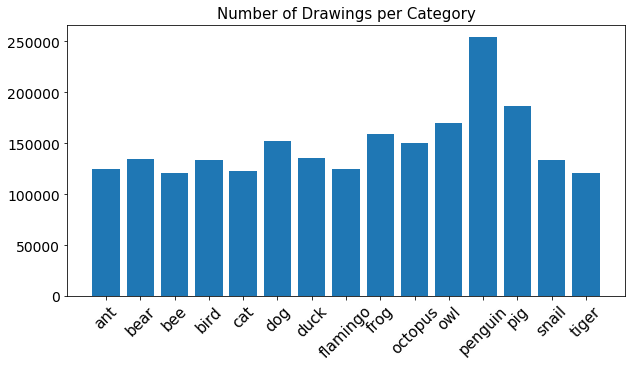

In [0]:
plt.figure(figsize=(10,5))
plt.bar(classes, size)
plt.title('Number of Drawings per Category', fontsize=15)
plt.yticks(fontsize=14)
plt.xticks(fontsize=15, rotation=45)

In [0]:
def plot_samples(input_array, rows=5, cols=5, title=''):
    
    fig, ax = plt.subplots(figsize=(cols,rows))
    ax.axis('off')
    plt.title(title)

    for i in list(range(0, min(len(input_array),(rows*cols)) )):      
        a = fig.add_subplot(rows,cols,i+1)
        imgplot = plt.imshow(input_array[i,:784].reshape((28,28)), cmap='gray_r', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])

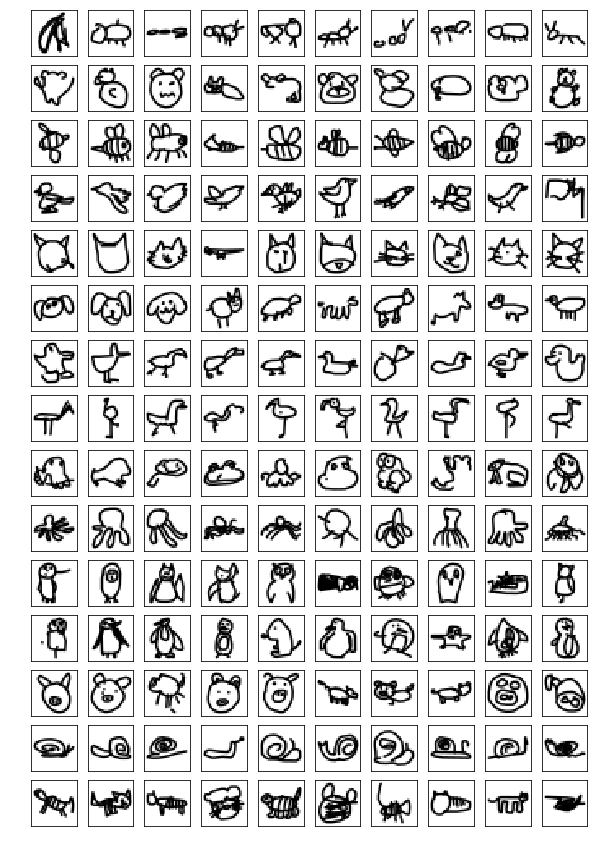

In [0]:
X_tmp, X_draw, y_tmp, y_draw = train_test_split(X, y, test_size=150, stratify=y, random_state=0)
X_draw.shape
draw = np.hstack((X_draw, y_draw.reshape(-1,1)))
draw = draw[draw[:,784].argsort()]
plot_samples(draw, rows=15, cols=10, title='')

In [0]:
del X_tmp, X_draw, y_tmp, y_draw

octopus


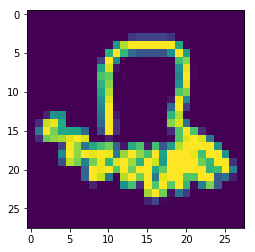

In [0]:
idx = randint(0, len(X_train))
plt.imshow(X_train[idx].reshape(28,28)) 
print(classes[int(y_train[idx].item())])

## Basic Architecture 

### Logistic Regression

In [0]:
npdata = np.hstack((X, y.reshape(-1,1)))
npdata.shape

(1500000, 785)

In [0]:
spark = SparkSession\
          .builder\
          .appName("Logistic Regression")\
          .getOrCreate()

In [0]:
tmp = map(lambda x: (Vectors.dense(x[:-1]), int(x[-1])), npdata)
data = spark.createDataFrame(tmp, schema=["features","label"])
data.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.0,0.0,0.0,0.0,...|    0|
|[0.0,0.0,0.0,0.0,...|    0|
|[0.0,0.0,0.0,0.0,...|    0|
|[0.0,0.0,0.0,0.0,...|    0|
|[0.0,0.0,0.0,0.0,...|    0|
+--------------------+-----+
only showing top 5 rows



In [0]:
(training, test) = data.randomSplit([0.8, 0.2])

In [0]:
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8,
                        featuresCol="features", labelCol="label")
lr_model = lr.fit(training)

In [0]:
predictions = lr_model.transform(test)
evaluator = MulticlassClassificationEvaluator(metricName="accuracy",
                                              labelCol="label",
                                              predictionCol="prediction")
accuracy = evaluator.evaluate(predictions)
accuracy

0.43165


In [0]:
spark.stop()

### CNN

In [0]:
num_classes = 15
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

# Reshape and normalize
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

X_train /= 255.0
X_test /= 255.0

# Convert class vectors to class matrices
y_test_copy = y_test.copy()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
# Define model
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu',
                  input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax')) 
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               401536    
_________________________________________________________________
dense_2 (Dense)              (None, 15)                1935      
Total para

In [0]:
# Train model
cnn = model.fit(X_train, y_train, batch_size=1000, epochs=30, verbose=1, validation_split=.1)

Train on 1080000 samples, validate on 120000 samples
Epoch 1/30
1080000/1080000 [==============================] - 248s 230us/step - loss: 0.6627 - acc: 0.7894 - val_loss: 0.6542 - val_acc: 0.7910
Epoch 2/30
1080000/1080000 [==============================] - 248s 230us/step - loss: 0.6187 - acc: 0.8026 - val_loss: 0.6340 - val_acc: 0.7980
Epoch 3/30
1080000/1080000 [==============================] - 248s 230us/step - loss: 0.5885 - acc: 0.8115 - val_loss: 0.6143 - val_acc: 0.8036
Epoch 4/30
1080000/1080000 [==============================] - 264s 244us/step - loss: 0.5648 - acc: 0.8185 - val_loss: 0.5973 - val_acc: 0.8091
Epoch 5/30
1080000/1080000 [==============================] - 262s 242us/step - loss: 0.5464 - acc: 0.8239 - val_loss: 0.5906 - val_acc: 0.8102
Epoch 6/30
1080000/1080000 [==============================] - 249s 231us/step - loss: 0.5303 - acc: 0.8288 - val_loss: 0.5916 - val_acc: 0.8100
Epoch 7/30
1080000/1080000 [==============================] - 251s 232us/step - los

In [0]:
# Evaluate model
print(model.metrics_names)
print(model.evaluate(X_test, y_test))

['loss', 'acc']
300000/300000 [==============================] - 74s 245us/step
[0.67158395109574, 0.80387]


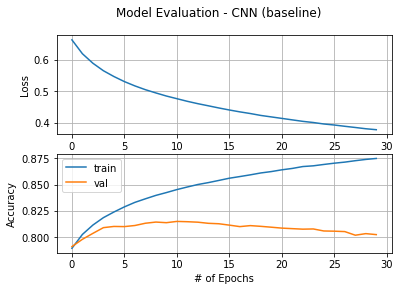

In [0]:
plt.figure()
plt.suptitle('Model Evaluation - CNN (baseline)')

# loss
plt.subplot(211)
plt.plot(cnn.history['loss'])
plt.grid()
plt.xlabel('# of Epochs')
plt.ylabel('Loss')

# acc
plt.subplot(212)
plt.plot(cnn.history['acc'])
plt.plot(cnn.history['val_acc'])
plt.grid()
plt.xlabel('# of Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

### Baseline

The accuracy of the training set increased with an increase in the number of epochs while the accuracy of the validation set started to drop after 10 epochs. To prevent the model from overfitting, the number of epochs was chosen to be 10. 


In [0]:
%%time

# Define model
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu',
                  input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax')) 
model.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
print(model.summary())

# Train model
cnn = model.fit(X_train, y_train, batch_size=1000, epochs=10, verbose=1, validation_split=.1)

# Evaluate model
print(model.metrics_names)
print(model.evaluate(X_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               401536    
_________________________________________________________________
dense_2 (Dense)              (None, 15)                1935      
Total para

###  Prediction on Baseline Model

#### Confusion Matrix

In [0]:
y_pred = model.predict_classes(X_test)
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test_copy, y_pred)
# np.savetxt("confusion_matrix.csv", mat, delimiter=",", fmt='%i')

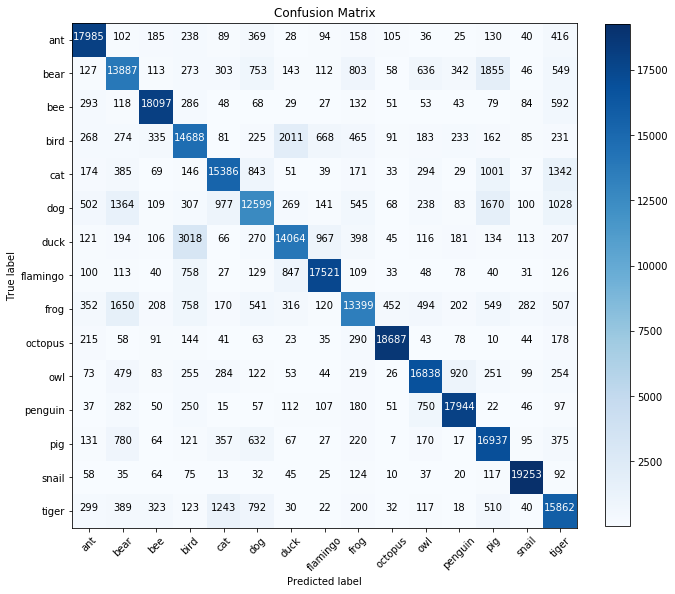

In [0]:
def plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues):

    plt.imshow(cm, cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar(fraction=0.045)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(10,10))
plot_confusion_matrix(mat, classes=classes)
plt.show()

#### Unsure Drawings

We visualized some drawings that our baseline model was very unsure about the label by filtering with p_max < 0.4.

/home/xl2719/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


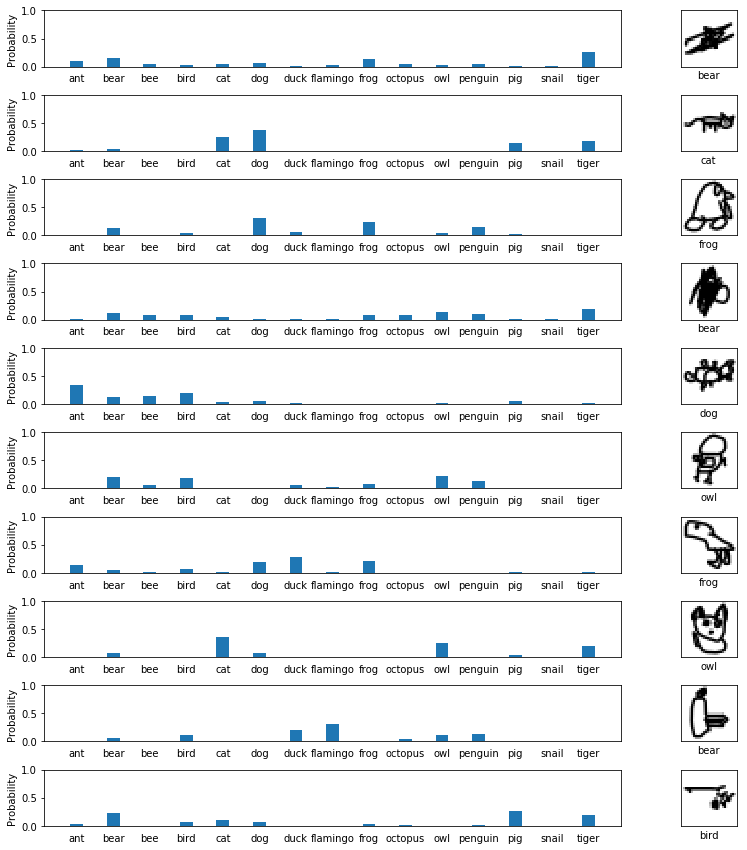

In [0]:
y_pred_p = model.predict(X_test)
p_max = np.amax(y_pred_p, axis=1)

fig, ax = plt.subplots(figsize=(40,15))

for i in list(range(10)):
    
    # Plot probabilities:
    ax = plt.subplot2grid((10, 15), (i, 0), colspan=4);
    plt.bar(np.arange(15), y_pred_p[p_max<0.4][i], 0.35, align='center');
    plt.xticks(np.arange(15), classes)
    plt.tick_params(axis='x', bottom='off', top='off')
    plt.ylabel('Probability')
    plt.ylim(0,1)
    plt.subplots_adjust(hspace = 0.5)

    # Plot picture:
    ax = plt.subplot2grid((10, 15), (i, 4));
    plt.imshow(X_test[p_max<0.4][i].reshape((28,28)),cmap='gray_r', interpolation='nearest');
    plt.xlabel(classes[int(y_test_copy[p_max<0.4][i])]);
    plt.xticks([])
    plt.yticks([])

#### Bird & Duck


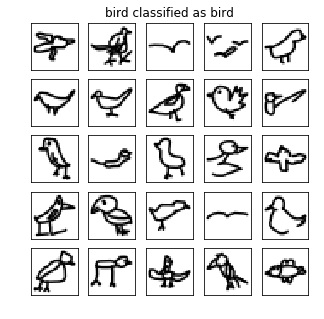

In [0]:
bird_as_bird = X_test[(y_test_copy == 3) & (y_pred == 3)] 
plot_samples(bird_as_bird, title='bird classified as bird')

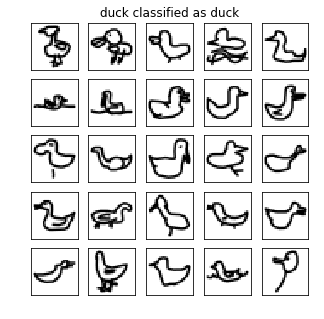

In [0]:
duck_as_duck = X_test[(y_test_copy == 6) & (y_pred == 6)] 
plot_samples(duck_as_duck, title='duck classified as duck')

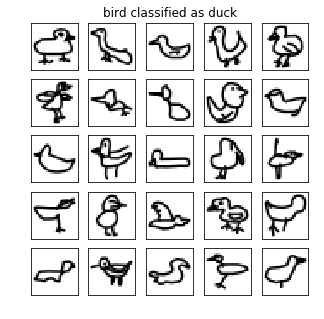

In [0]:
bird_as_duck = X_test[(y_test_copy == 3) & (y_pred == 6)] 
plot_samples(bird_as_duck, title = 'bird classified as duck')

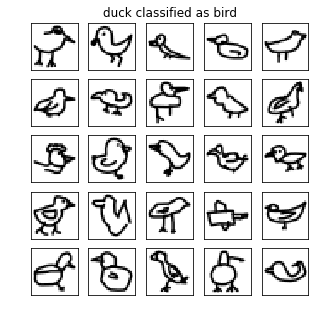

In [0]:
duck_as_bird = X_test[(y_test_copy == 6) & (y_pred == 3)] 
plot_samples(duck_as_bird, title = 'duck classified as bird')

#### Bear

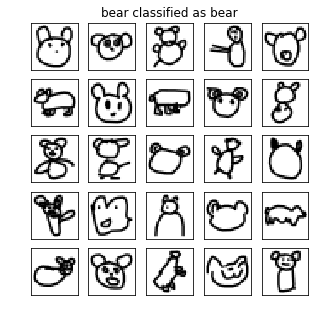

In [0]:
bear_as_bear = X_test[(y_test_copy == 1) & (y_pred == 1)] 
plot_samples(bear_as_bear, title='bear classified as bear')

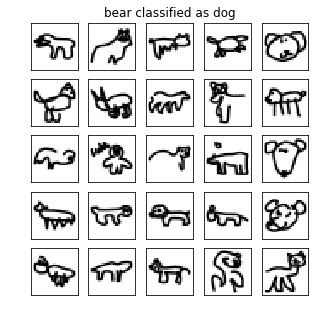

In [0]:
bear_as_dog = X_test[(y_test_copy == 1) & (y_pred == 5)] 
plot_samples(bear_as_dog, title='bear classified as dog')

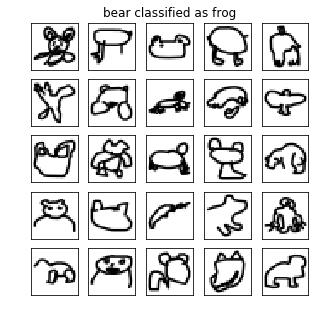

In [0]:
bear_as_frog = X_test[(y_test_copy == 1) & (y_pred == 8)] 
plot_samples(bear_as_frog, title='bear classified as frog')

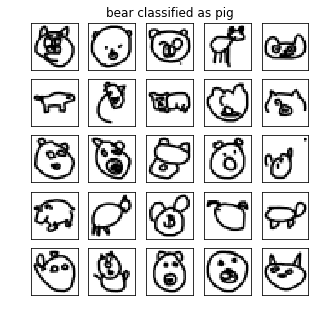

In [0]:
bear_as_pig = X_test[(y_test_copy == 1) & (y_pred == 12)] 
plot_samples(bear_as_pig, title='bear classified as pig')

## Data Augmentation - imgaug

### Flip: 0.812

In [0]:
# Define model
model_aug = Sequential()
model_aug.add(Conv2D(32, (3, 3), padding='same', activation='relu',
                     input_shape=input_shape))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))
model_aug.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))
model_aug.add(Flatten())
model_aug.add(Dense(128, activation='relu'))
model_aug.add(Dense(num_classes, activation='softmax')) 
model_aug.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Define augmentation
seq = iaa.Sequential([
    # horizontally flip 50% of the images
    iaa.Fliplr(0.5) 
])

X_train_aug = seq.augment_images(X_train)

# Train model
cnn_flip = model_aug.fit(X_train_aug, y_train, batch_size=1000, epochs=10, verbose=1, validation_split=.1)

# Evaluate model
print(model_aug.metrics_names)
print(model_aug.evaluate(X_test, y_test))

Train on 1080000 samples, validate on 120000 samples
Epoch 1/10
1080000/1080000 [==============================] - 136s 126us/step - loss: 1.0023 - acc: 0.6878 - val_loss: 0.7965 - val_acc: 0.7480
Epoch 2/10
1080000/1080000 [==============================] - 131s 121us/step - loss: 0.7317 - acc: 0.7690 - val_loss: 0.7018 - val_acc: 0.7768
Epoch 3/10
1080000/1080000 [==============================] - 132s 122us/step - loss: 0.6604 - acc: 0.7902 - val_loss: 0.6570 - val_acc: 0.7912
Epoch 4/10
1080000/1080000 [==============================] - 131s 121us/step - loss: 0.6216 - acc: 0.8017 - val_loss: 0.6292 - val_acc: 0.7996
Epoch 5/10
1080000/1080000 [==============================] - 133s 123us/step - loss: 0.5941 - acc: 0.8097 - val_loss: 0.6153 - val_acc: 0.8034
Epoch 6/10
1080000/1080000 [==============================] - 133s 123us/step - loss: 0.5722 - acc: 0.8166 - val_loss: 0.6046 - val_acc: 0.8071
Epoch 7/10
1080000/1080000 [==============================] - 132s 122us/step - los

### Scale: 0.805

In [0]:
# Define model
model_aug = Sequential()
model_aug.add(Conv2D(32, (3, 3), padding='same', activation='relu',
                     input_shape=input_shape))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))
model_aug.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))
model_aug.add(Flatten())
model_aug.add(Dense(128, activation='relu'))
model_aug.add(Dense(num_classes, activation='softmax')) 
model_aug.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Define augmentation
seq = iaa.Sequential([
    # scale to 80-120% of image height/width (each axis independently)
    iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)})
])

X_train_aug = seq.augment_images(X_train)

# Train model
cnn_scale = model_aug.fit(X_train_aug, y_train, batch_size=1000, epochs=10, verbose=1, validation_split=.1)

# Evaluate model
print(model_aug.metrics_names)
print(model_aug.evaluate(X_test, y_test))

Train on 1080000 samples, validate on 120000 samples
Epoch 1/10
1080000/1080000 [==============================] - 128s 119us/step - loss: 1.0948 - acc: 0.6590 - val_loss: 0.8837 - val_acc: 0.7238
Epoch 2/10
1080000/1080000 [==============================] - 127s 117us/step - loss: 0.8115 - acc: 0.7449 - val_loss: 0.7687 - val_acc: 0.7569
Epoch 3/10
1080000/1080000 [==============================] - 126s 117us/step - loss: 0.7284 - acc: 0.7695 - val_loss: 0.7182 - val_acc: 0.7717
Epoch 4/10
1080000/1080000 [==============================] - 125s 115us/step - loss: 0.6822 - acc: 0.7826 - val_loss: 0.6832 - val_acc: 0.7829
Epoch 5/10
1080000/1080000 [==============================] - 125s 116us/step - loss: 0.6498 - acc: 0.7929 - val_loss: 0.6690 - val_acc: 0.7864
Epoch 6/10
1080000/1080000 [==============================] - 126s 117us/step - loss: 0.6265 - acc: 0.7998 - val_loss: 0.6557 - val_acc: 0.7912
Epoch 7/10
1080000/1080000 [==============================] - 126s 117us/step - los

### Compare

The validation accuracy did not improve with neither of the methods. This may be the result that the dataset we used for baseline was already big enough and given the nature of the drawings any further enhacements of exisiting data would not help much. Therefore, we decided not to apply any data augmentation techniques on the exisiting dataset.  


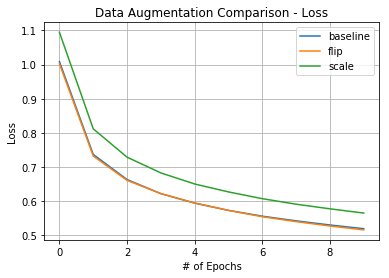

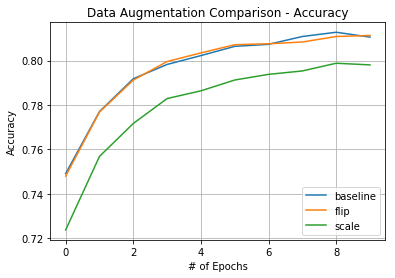

In [0]:
# loss
plt.figure()
plt.title('Data Augmentation Comparison - Loss')
plt.plot(cnn.history['loss'])
plt.plot(cnn_flip.history['loss'])
plt.plot(cnn_scale.history['loss'])
plt.grid()
plt.xlabel('# of Epochs')
plt.ylabel('Loss')
plt.legend(['baseline', 'flip', 'scale'], loc = 'upper right')
plt.show()

# acc
plt.figure()
plt.title('Data Augmentation Comparison - Accuracy')
plt.plot(cnn.history['val_acc'])
plt.plot(cnn_flip.history['val_acc'])
plt.plot(cnn_scale.history['val_acc'])
plt.grid()
plt.xlabel('# of Epochs')
plt.ylabel('Accuracy')
plt.legend(['baseline', 'flip', 'scale'], loc = 'lower right')
plt.show()

## Model Enhancement

We tried to improve the performance by enhancing the model using some general approaches such as dropout and batch normalization. 

### Dropout

Dropout is usually added to the network at two different positions and varies:
1. after the second pooling layer
2. after the first dense layer

After comparsion,  a dropout of 0.5 after the second pooling layer showed the best performance result. 


#### Dropout 1 - 0.25：0.817

In [0]:
%%time

# Define model
model_d = Sequential()
model_d.add(Conv2D(32, (3, 3), padding='same', activation='relu',
                   input_shape=input_shape))
model_d.add(MaxPooling2D(pool_size=(2, 2)))
model_d.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_d.add(MaxPooling2D(pool_size=(2, 2)))
model_d.add(Dropout(0.25))
model_d.add(Flatten())
model_d.add(Dense(128, activation='relu'))
model_d.add(Dense(num_classes, activation='softmax')) 
model_d.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
print(model_d.summary())

# Train model
cnn_d1_25 = model_d.fit(X_train, y_train, batch_size=1000, epochs=10, verbose=1, validation_split=.1)

# Evaluate model
print(model_d.metrics_names)
print(model_d.evaluate(X_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               401536    
__________

#### Dropout 1 - 0.5：0.819

In [0]:
%%time

# Define model
model_d = Sequential()
model_d.add(Conv2D(32, (3, 3), padding='same', activation='relu',
                   input_shape=input_shape))
model_d.add(MaxPooling2D(pool_size=(2, 2)))
model_d.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_d.add(MaxPooling2D(pool_size=(2, 2)))
model_d.add(Dropout(0.5))
model_d.add(Flatten())
model_d.add(Dense(128, activation='relu'))
model_d.add(Dense(num_classes, activation='softmax')) 
model_d.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
print(model_d.summary())

# Train model
cnn_d1_50 = model_d.fit(X_train, y_train, batch_size=1000, epochs=10, verbose=1, validation_split=.1)

# Evaluate model
print(model_d.metrics_names)
print(model_d.evaluate(X_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               401536    
__________

#### Dropout 1 - 0.5 & Dropout 2 - 0.25： 0.811

In [0]:
%%time

# Define model
model_d = Sequential()
model_d.add(Conv2D(32, (3, 3), padding='same', activation='relu',
                   input_shape=input_shape))
model_d.add(MaxPooling2D(pool_size=(2, 2)))
model_d.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_d.add(MaxPooling2D(pool_size=(2, 2)))
model_d.add(Dropout(0.5))
model_d.add(Flatten())
model_d.add(Dense(128, activation='relu'))
model_d.add(Dropout(0.25))
model_d.add(Dense(num_classes, activation='softmax')) 
model_d.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
print(model_d.summary())

# Train model
cnn_d1_50_d2_25 = model_d.fit(X_train, y_train, batch_size=1000, epochs=10, verbose=1, validation_split=.1)

# Evaluate model
print(model_d.metrics_names)
print(model_d.evaluate(X_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               401536    
__________

#### Dropout 1 - 0.5 & Dropout 2 - 0.5： 0.797

In [0]:
%%time

# Define model
model_d = Sequential()
model_d.add(Conv2D(32, (3, 3), padding='same', activation='relu',
                   input_shape=input_shape))
model_d.add(MaxPooling2D(pool_size=(2, 2)))
model_d.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_d.add(MaxPooling2D(pool_size=(2, 2)))
model_d.add(Dropout(0.5))
model_d.add(Flatten())
model_d.add(Dense(128, activation='relu'))
model_d.add(Dropout(0.5))
model_d.add(Dense(num_classes, activation='softmax')) 
model_d.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
print(model_d.summary())

# Train model
cnn_d1_50_d2_50 = model_d.fit(X_train, y_train, batch_size=1000, epochs=10, verbose=1, validation_split=.1)

# Evaluate model
print(model_d.metrics_names)
print(model_d.evaluate(X_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               401536    
__________

### Batch Normalization 0.812

In [0]:
%%time

# Define model
model_b = Sequential()
model_b.add(Conv2D(32, (3, 3), padding='same', activation='relu',
                  input_shape=input_shape))
model_b.add(BatchNormalization())
model_b.add(MaxPooling2D(pool_size=(2, 2)))
model_b.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_b.add(BatchNormalization())
model_b.add(MaxPooling2D(pool_size=(2, 2)))
model_b.add(Flatten())
model_b.add(Dense(128, activation='relu'))
model_b.add(Dense(num_classes, activation='softmax')) 
model_b.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
print(model_b.summary())

# Train model
cnn_b = model_b.fit(X_train, y_train, batch_size=1000, epochs=10, verbose=1, validation_split=.1)

# Evaluate model
print(model_b.metrics_names)
print(model_b.evaluate(X_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 3136)              0         
__________

### Dropout + Batch Normalization 0.817

In [0]:
%%time

# Define model
model_both = Sequential()
model_both.add(Conv2D(32, (3, 3), padding='same', activation='relu',
                  input_shape=input_shape))
model_both.add(BatchNormalization())
model_both.add(MaxPooling2D(pool_size=(2, 2)))
model_both.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_both.add(BatchNormalization())
model_both.add(MaxPooling2D(pool_size=(2, 2)))
model_both.add(Dropout(0.5))
model_both.add(Flatten())
model_both.add(Dense(128, activation='relu'))
model_both.add(Dense(num_classes, activation='softmax')) 
model_both.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])
print(model_both.summary())

# Train model
cnn_both = model_both.fit(X_train, y_train, batch_size=1000, epochs=10, verbose=1, validation_split=.1)

# Evaluate model
print(model_both.metrics_names)
print(model_both.evaluate(X_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 7, 7, 64)          0         
__________

### Compare

By utilizing the batch normalization, the loss significantly decreased while the accuracy of the validation set was quite unstable. By further adding in dropout layers to prevent it from overfitting, the result became more promising. 

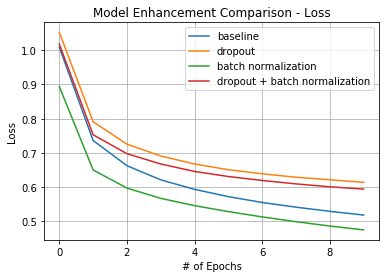

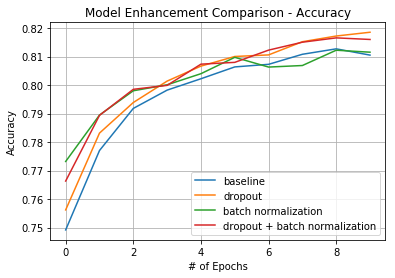

In [0]:
# loss
plt.figure()
plt.title('Model Enhancement Comparison - Loss')
plt.plot(cnn.history['loss'])
plt.plot(cnn_d1_50.history['loss'])
plt.plot(cnn_b.history['loss'])
plt.plot(cnn_both.history['loss'])
plt.grid()
plt.xlabel('# of Epochs')
plt.ylabel('Loss')
plt.legend(['baseline', 'dropout', 'batch normalization', 'dropout + batch normalization'], loc = 'upper right')
plt.show()

# acc
plt.figure()
plt.title('Model Enhancement Comparison - Accuracy')
plt.plot(cnn.history['val_acc'])
plt.plot(cnn_d1_50.history['val_acc'])
plt.plot(cnn_b.history['val_acc'])
plt.plot(cnn_both.history['val_acc'])
plt.grid()
plt.xlabel('# of Epochs')
plt.ylabel('Accuracy')
plt.legend(['baseline', 'dropout', 'batch normalization', 'dropout + batch normalization'], loc = 'lower right')
plt.show()

## Experiment Results

We chose the model with both dropout and batch normalization as our final model.

True label: bee
Predicted label:
bee: 0.98444134
tiger: 0.007083304
bird: 0.0035171434


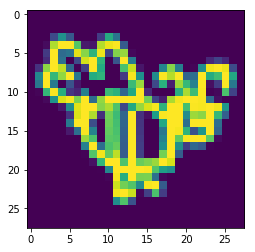

In [0]:
idx = randint(0, len(X_test))
plt.imshow(X_test[idx].reshape(28,28)) 
print('True label: ' + classes[int(y_test_copy[idx].item())])

pred = model_both.predict(np.expand_dims(X_test[idx], axis=0))[0]
ind = (-pred).argsort()[:3]
prob = np.sort(pred)[::-1][:3]
print('Predicted label:')
for i in range(3):
    print(classes[ind[i]] + ': ' + str(prob[i]))

### Confusion Matrix

In [0]:
y_pred_f = model_both.predict_classes(X_test)
mat_f = confusion_matrix(y_test_copy, y_pred_f)

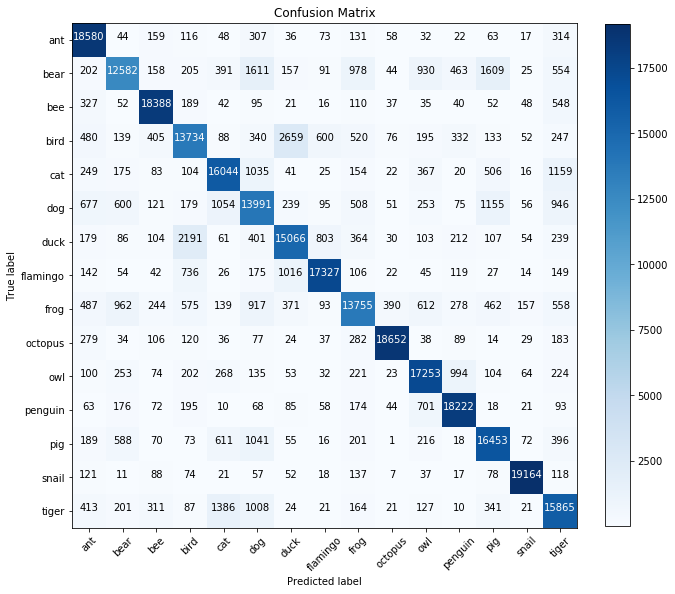

In [0]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(mat_f, classes=classes)
plt.show()

### Unsure Drawings

We visualized some drawings that our final model was very unsure about the label by filtering with p_max < 0.4.

/home/xl2719/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


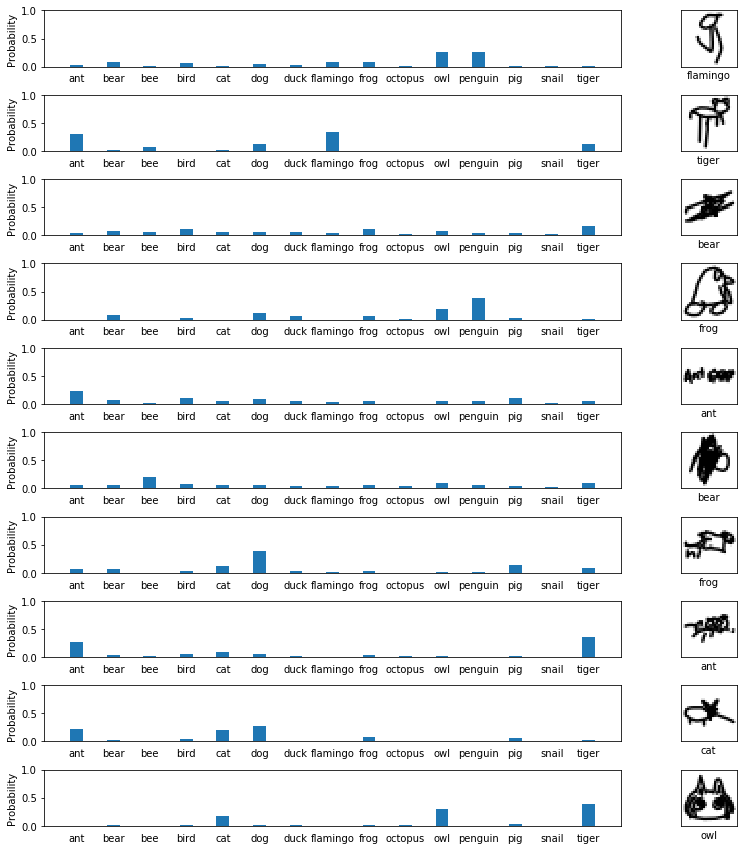

In [0]:
y_pred_f_p = model_both.predict(X_test)
p_max = np.amax(y_pred_f_p, axis=1)

fig, ax = plt.subplots(figsize=(40,15))

for i in list(range(10)):
    
    # Plot probabilities:
    ax = plt.subplot2grid((10, 15), (i, 0), colspan=4);
    plt.bar(np.arange(15), y_pred_f_p[p_max<0.4][i], 0.35, align='center');
    plt.xticks(np.arange(15), classes)
    plt.tick_params(axis='x', bottom='off', top='off')
    plt.ylabel('Probability')
    plt.ylim(0,1)
    plt.subplots_adjust(hspace = 0.5)

    # Plot picture:
    ax = plt.subplot2grid((10, 15), (i, 4));
    plt.imshow(X_test[p_max<0.4][i].reshape((28,28)),cmap='gray_r', interpolation='nearest');
    plt.xlabel(classes[int(y_test_copy[p_max<0.4][i])]);
    plt.xticks([])
    plt.yticks([])

## Web Preparation

In [0]:
!pip install tensorflowjs 

In [0]:
model_both.save('keras.h5')

In [0]:
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/

In [0]:
!cp class_names.txt model/class_names.txt

In [0]:
!zip -r model.zip model 

In [0]:
from google.colab import files
files.download('model.zip')